# Simulation

This notebook simulates one year of data at Cork Airport, Ireland. About fifty years of historical weather data from hundreds of weather stations around Ireland is available from the Met Eireann website [1]. To perform this simulation, a subset of the data available from Cork Airport is used to identify the features of a few of the variables from that data.

In [2]:
# imports
# numerical computing
import numpy as np
# pseudo-random number generation
from numpy.random import default_rng
# data management and manipulation
import pandas as pd 
# plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# initialise the random number generator
# seeded for reproducibility
rng = default_rng(99)

First the data is downloaded. The Met Eireann website provides it as a csv file and some text files zipped together. This was done manually, with the downloaded archive unzipped to the `data/` directory. The entire dataset from 1962 to present was downloaded, and is present in the `data/` folder, but only four variables tracked over the course of one year will be used her. The four variables used will be:
- Minimum temperature (°C)
- Maximum temperature (°C)
- Precipitation Amount (mm)
- Sunshine duration (hours)

There is one record for each day and the date will be used to index the DataFrame. The dataset will be subset to include all records from 01-12-2020 to 30-11-2021; 365 records. For convenience, a month column will be added.

The purpose of this dataset is to examine the nature of each meteorological phenomenon with a view to creating random data representing one year of the same phenomena that is indistinguishable from the real data.

Next, the data is loaded into a DataFrame:

In [4]:
# Read csv to dataframe
df = pd.read_csv('data/source/dly3904.csv', header=21)
# subset the columns of interest
df = df[['date', 'maxtp', 'mintp', 'rain', 'sun']]
# cast date column as date type
df['date'] = pd.to_datetime(df['date'])
# subset to one year of data
one_year = (df['date'] >= '2020-12-1') & (df['date'] <= '2021-11-30')
df = df.loc[one_year]
# Set date as index
df.set_index('date', inplace=True)
# cast sun and ran as floats
df = df.astype({'rain': 'float64', 'sun': 'float64'})
# add a month column
df['month'] = pd.DatetimeIndex(df.index).month_name()

In [5]:
# Dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2020-12-01 to 2021-11-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   maxtp   365 non-null    float64
 1   mintp   365 non-null    float64
 2   rain    365 non-null    float64
 3   sun     365 non-null    float64
 4   month   365 non-null    object 
dtypes: float64(4), object(1)
memory usage: 17.1+ KB


In [6]:
# Take a look at the data
df.head()

,maxtp,mintp,rain,sun,month
date,,,,,
2020-12-01,12.0,7.7,0.0,2.0,December
2020-12-02,9.0,4.0,0.1,1.0,December
2020-12-03,5.3,0.1,1.9,3.0,December
2020-12-04,6.2,0.8,1.5,4.8,December
2020-12-05,6.6,4.7,0.9,0.9,December


In [7]:
# view some descriptive statistics
np.round(df.describe(), 2)

,maxtp,mintp,rain,sun
count,365.00,365.00,365.00,365.00
mean,13.10,7.00,3.51,4.25
std,4.97,4.47,6.21,4.03
min,1.90,-2.70,0.00,0.00
25%,9.70,3.50,0.00,0.40
50%,12.80,6.70,0.60,3.20
75%,16.80,11.00,4.60,7.00
max,25.70,17.40,50.10,15.20


Overall, the distributions of the data are difficult to pin down visually. It seems likely that a stepwise simulation might be more appropriate than a random distribution.

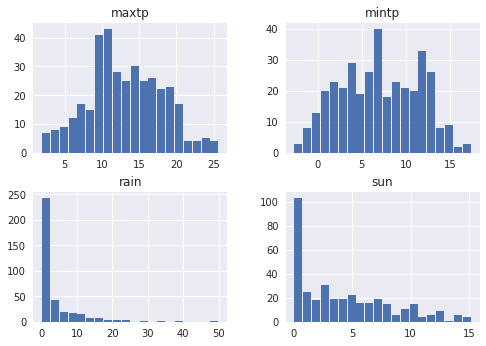

In [8]:
# Overall distribution of each variable
with plt.style.context('seaborn'):
    df.drop('month', axis=1).hist(rwidth=0.9, bins=20)

There's an extremely strong correlation between minimum and maximum temperature and weaker ones between rainfall and sunshine duration, and between maximum temperature and sunshine duration. There's no real correlation between rainfall and temperature or between sun and minimum temperature.

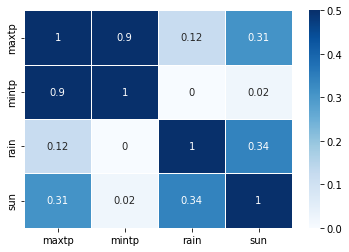

In [9]:
# Examine correlations between variables
corr = df.corr()
sns.heatmap(abs(corr.round(2)), annot=True, linewidths=0.5, cmap='Blues', vmax=0.5)
plt.show()

Looking at temperature first. As noted above there is an unsurprisingly high correlation between the minimum and maximum temperatures, which track one another closely throughout the year. Also unsurprisingly, they are both higher and further apart in the summer months. There is an upward trend from January until mid-July, and a downward trend from september until January.

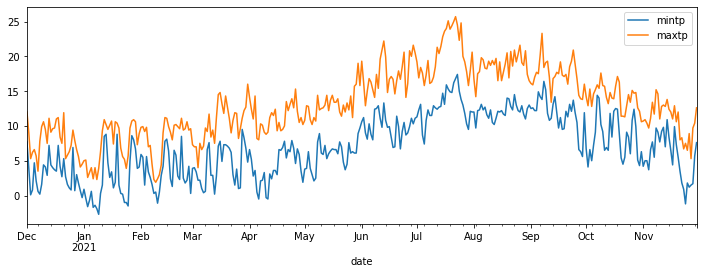

In [10]:
# Plot min and max temperatures
df[['mintp', 'maxtp']].plot(figsize=(12, 4));

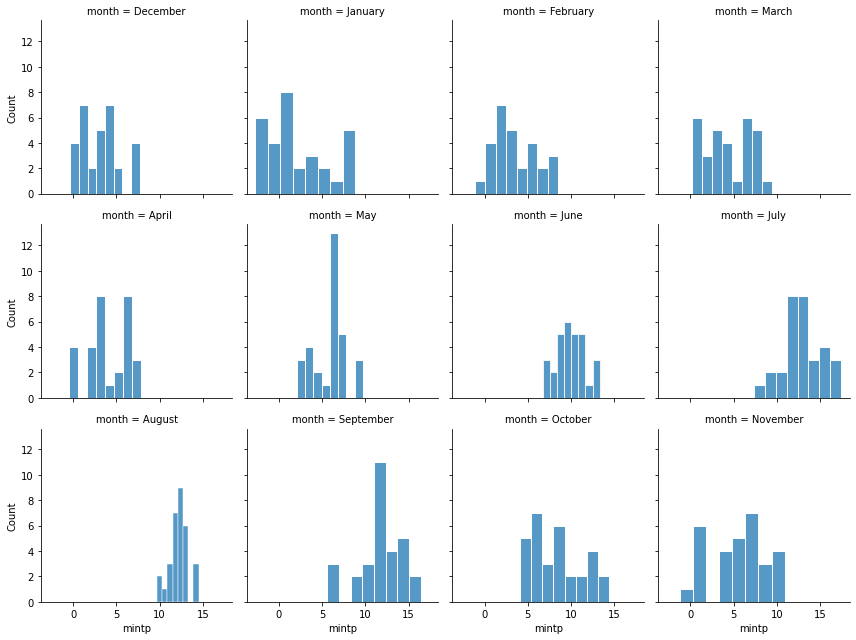

In [13]:
# Minimum temperature histograms for each month
g = sns.FacetGrid(df, col="month", col_wrap=4)
g.map(sns.histplot, "mintp", edgecolor='white', bins=8);

1. rand between min and max for month
2. choose up or down
3. if at max go down, if at min go up, otherwise random
4. 

1. count ups and downs for each month
Day 1: Random value between min and max for that month
Every other day: Randomly choose up or down using bias based on ups vs downs for that month
       If at max must go down, if at min must go up. 
       If going up must go up by a random number between current value and max value
       If going down must go down by a random number between current value and min value
When a new month starts, update bias min and max for that month.
If it looks ok swithc to weeks

In [20]:
df['mintpupdown']=df['mintp'].diff()
np.sum(df['mintpupdown'] < 0)

196

In [33]:
df_ud = pd.DataFrame()
df_ud['down'] = df[df['mintpupdown'] < 0].groupby('month').count()['mintpupdown']
df_ud['up'] = df[df['mintpupdown'] > 0].groupby('month').count()['mintpupdown']

In [34]:
df_updown

,mintpupdown,up
month,,
April,16,13
August,17,13
December,21,9
February,16,12
January,16,14
July,16,14
June,14,16
March,16,12
May,13,16


General Steps
1. Identify variables and give them types
1. Identify distribution, mean, median, standard deviation for each variable
1. Identify Relationships between variables

Specific Steps
The max temp, min temp, rainfall (mm), and the sun (hours) will be simulated for every day for one year. The granularity of the simulation will be one month. For the moment this will not be a moving window simply a calendar month.

The variables will all be floats, except for the month which will be a string.

The strategy will be to estimate the distribution, etc for each variable for each month and then to adjust the relationships between variables as necessary.

### References

[1] Met Eireann &mdash; Irish Meteorological Service, Historical Data [online]. Available from https://www.met.ie/climate/available-data/historical-data



In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2020-12-01 to 2021-11-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   maxtp   365 non-null    float64
 1   mintp   365 non-null    float64
 2   rain    365 non-null    float64
 3   sun     365 non-null    float64
 4   month   365 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 17.1 KB
